In [1]:
import tensorflow as tf
from src.dataset import dataset_tf, validation_tf
from src.audio import to_mfccs_dataset
from src.model import get_seq_model, get_conv_model, callbacks
from src.plots import plot_history, plot_mfccs

In [2]:
train_ds, val_ds, label_names = dataset_tf("./dataset/osbh_pure")

Found 856 files belonging to 2 classes.
Using 685 files for training.
Using 171 files for validation.
label names: ['no_queen' 'queen']
(TensorSpec(shape=(None, 4000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Example audio shape: (32, 4000)
Example label shape: (32,)


2024-02-29 23:36:33.676003: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Max
2024-02-29 23:36:33.676028: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-02-29 23:36:33.676036: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-02-29 23:36:33.676067: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-29 23:36:33.676087: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


513 44100
Label: no_queen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)
513 44100
Label: no_queen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)


In [3]:
train_mfccs_ds = to_mfccs_dataset(train_ds)
val_mfccs_ds = to_mfccs_dataset(val_ds)

513 44100
513 44100


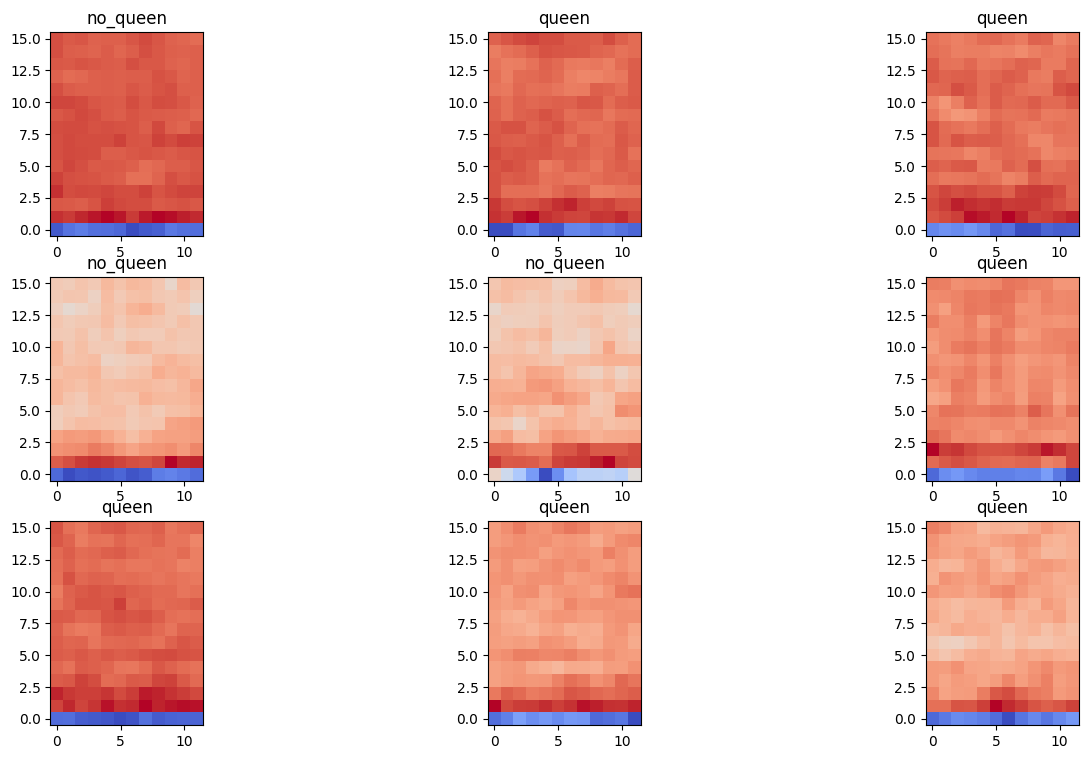

In [4]:
for example_spectrograms, example_spect_labels in train_mfccs_ds.take(1):
  break
# (TensorShape([118, 129, 1])
input_shape = example_spectrograms.shape[1:]
plot_mfccs(example_spectrograms, example_spect_labels, label_names)

In [5]:
train_mfccs_ds = train_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))
val_mfccs_ds = val_mfccs_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))
for example_spectrograms, example_spect_labels in train_mfccs_ds.take(1):
  break
input_shape = example_spectrograms.shape[1:]
input_shape

TensorShape([12, 16, 1])

In [6]:
train_mfccs_ds = train_mfccs_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_mfccs_ds = val_mfccs_ds.cache().prefetch(tf.data.AUTOTUNE)

# Sequential model

In [7]:
model_seq = get_seq_model(input_shape, len(label_names), train_mfccs_ds)
model_seq.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

2024-02-29 23:36:35.176224: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [8]:
history = model_seq.fit(
    train_mfccs_ds,
    validation_data=val_mfccs_ds,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
 1/22 [>.............................] - ETA: 10s - loss: 0.7034 - accuracy: 0.4688

2024-02-29 23:36:35.850840: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


22/22 [==============================] - 1s 30ms/step - loss: 0.5471 - accuracy: 0.7387 - val_loss: 0.3086 - val_accuracy: 0.9006
Epoch 2/50
22/22 [==============================] - 0s 13ms/step - loss: 0.2895 - accuracy: 0.9036 - val_loss: 0.2622 - val_accuracy: 0.8947
Epoch 3/50
22/22 [==============================] - 0s 13ms/step - loss: 0.1948 - accuracy: 0.9358 - val_loss: 0.1941 - val_accuracy: 0.9532
Epoch 4/50
22/22 [==============================] - 0s 14ms/step - loss: 0.1321 - accuracy: 0.9606 - val_loss: 0.2078 - val_accuracy: 0.9474
Epoch 5/50
22/22 [==============================] - 0s 14ms/step - loss: 0.1254 - accuracy: 0.9635 - val_loss: 0.2230 - val_accuracy: 0.9357
Epoch 6/50
22/22 [==============================] - 0s 13ms/step - loss: 0.0767 - accuracy: 0.9839 - val_loss: 0.2611 - val_accuracy: 0.9240
Epoch 7/50
22/22 [==============================] - 0s 13ms/step - loss: 0.0470 - accuracy: 0.9898 - val_loss: 0.2964 - val_accuracy: 0.9357
Epoch 8/50
22/22 [======

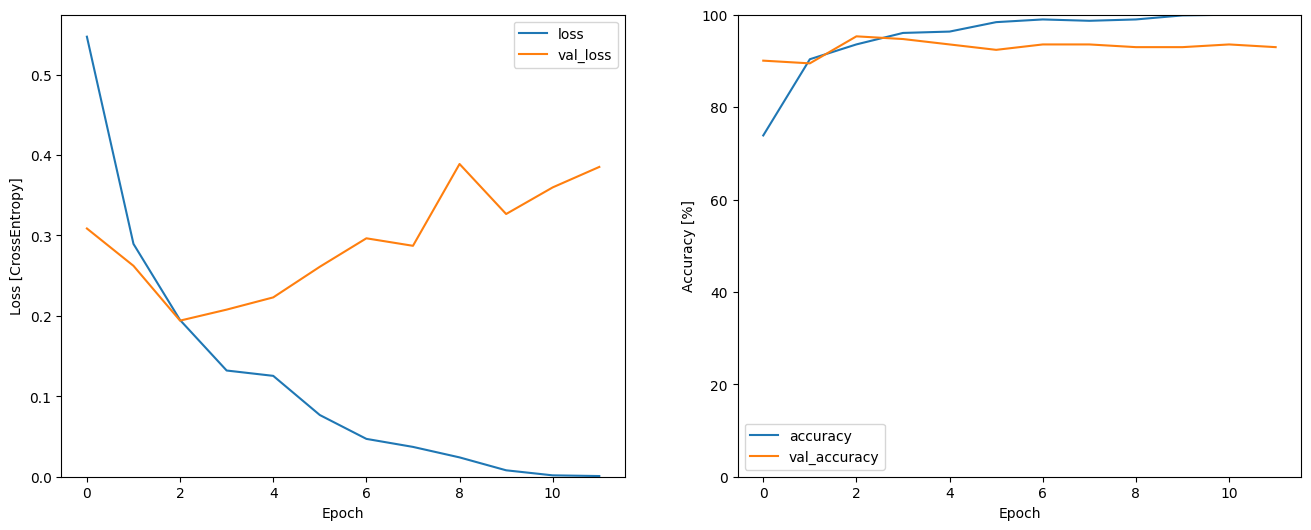

In [9]:
plot_history(history)

# Convolutional

In [10]:
model_conv = get_conv_model(input_shape, len(label_names))
model_conv.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [11]:
history = model_conv.fit(
    train_mfccs_ds, 
    validation_data=val_mfccs_ds, 
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
22/22 [==============================] - 1s 17ms/step - loss: 0.5652 - accuracy: 0.7518 - val_loss: 0.4250 - val_accuracy: 0.9006
Epoch 2/50
22/22 [==============================] - 0s 8ms/step - loss: 0.3809 - accuracy: 0.8745 - val_loss: 0.3500 - val_accuracy: 0.8246
Epoch 3/50
22/22 [==============================] - 0s 8ms/step - loss: 0.3184 - accuracy: 0.8891 - val_loss: 0.2719 - val_accuracy: 0.8772
Epoch 4/50
22/22 [==============================] - 0s 7ms/step - loss: 0.2598 - accuracy: 0.9153 - val_loss: 0.3432 - val_accuracy: 0.8480
Epoch 5/50
22/22 [==============================] - 0s 7ms/step - loss: 0.2318 - accuracy: 0.9226 - val_loss: 0.2272 - val_accuracy: 0.9181
Epoch 6/50
22/22 [==============================] - 0s 7ms/step - loss: 0.2072 - accuracy: 0.9328 - val_loss: 0.1911 - val_accuracy: 0.9240
Epoch 7/50
22/22 [==============================] - 0s 8ms/step - loss: 0.1760 - accuracy: 0.9460 - val_loss: 0.1825 - val_accuracy: 0.9357
Epoch 8/50
22/22 [=

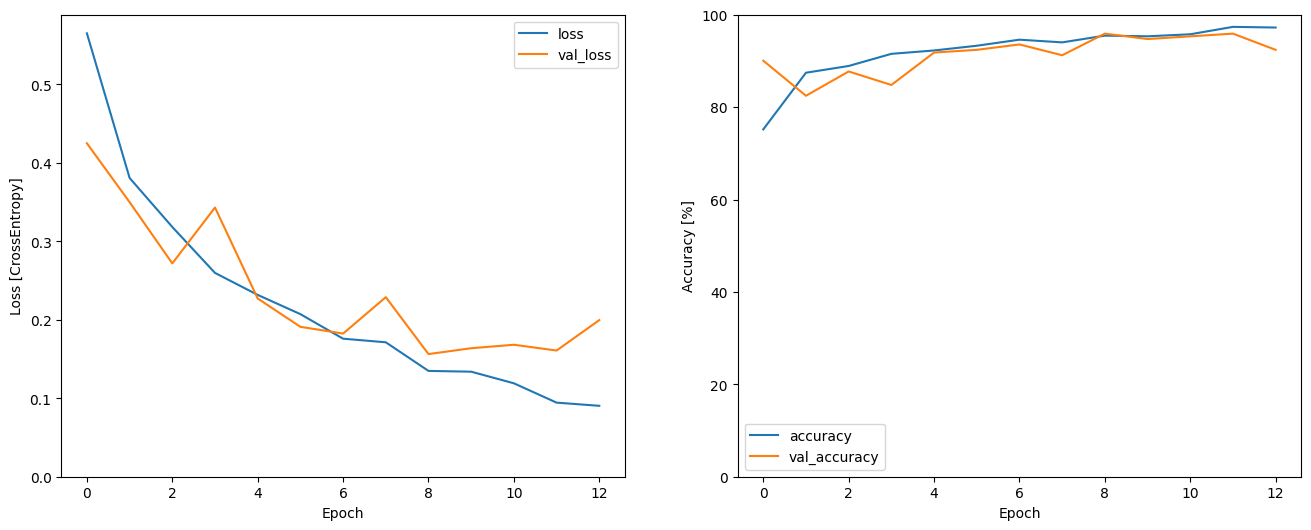

In [12]:
plot_history(history)

In [13]:
model_conv.save("osbh.h5")

/Users/lantain/miniconda3/envs/tf/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Validation

In [14]:
validation_ds = validation_tf("./dataset/osbh_pure_validation")
validation_ds = to_mfccs_dataset(validation_ds)
validation_ds = validation_ds.map(lambda x, y: (tf.expand_dims(x, -1), y))
validation_ds = validation_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)

Found 20 files belonging to 2 classes.
Using 1 files for training.
Using 19 files for validation.
label names: ['noqueen' 'queen']
(TensorSpec(shape=(None, 4000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Example audio shape: (2, 4000)
Example label shape: (2,)
513 44100
Label: noqueen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)
513 44100
Label: queen
Waveform shape: (4000,)
MFCCs shape: (12, 16)
Spectrogram shape: (118, 129, 1)
513 44100


In [15]:
model = tf.keras.models.load_model("osbh.h5")
results = model.evaluate(validation_ds)
print("Loss:", results[0])
print("Accuracy:", results[1])
results


10/10 [==============================] - 1s 68ms/step - loss: 0.2909 - accuracy: 0.8947
Loss: 0.29093536734580994
Accuracy: 0.8947368264198303


[0.29093536734580994, 0.8947368264198303]

In [17]:
accuracy_list = []
for example_spectrograms, example_spect_labels in validation_ds:
    print(example_spect_labels)
    accuracy = model.evaluate(example_spectrograms, example_spect_labels)
    accuracy_list.append(accuracy)
accuracy_list

tf.Tensor([1 0], shape=(2,), dtype=int32)
1/1 [==============================] - 0s 39ms/step - loss: 0.1932 - accuracy: 1.0000
tf.Tensor([1], shape=(1,), dtype=int32)
1/1 [==============================] - 0s 22ms/step - loss: 0.0020 - accuracy: 1.0000
tf.Tensor([0 1], shape=(2,), dtype=int32)
1/1 [==============================] - 0s 20ms/step - loss: 0.1627 - accuracy: 1.0000
tf.Tensor([0 1], shape=(2,), dtype=int32)
1/1 [==============================] - 0s 18ms/step - loss: 0.0087 - accuracy: 1.0000
tf.Tensor([0 1], shape=(2,), dtype=int32)
1/1 [==============================] - 0s 17ms/step - loss: 0.0382 - accuracy: 1.0000
tf.Tensor([0 1], shape=(2,), dtype=int32)
1/1 [==============================] - 0s 18ms/step - loss: 0.2247 - accuracy: 1.0000
tf.Tensor([1 0], shape=(2,), dtype=int32)
1/1 [==============================] - 0s 18ms/step - loss: 0.2015 - accuracy: 1.0000
tf.Tensor([0 0], shape=(2,), dtype=int32)
1/1 [==============================] - 0s 17ms/step - loss: 0.85

[[0.19316326081752777, 1.0],
 [0.001966329989954829, 1.0],
 [0.16267095506191254, 1.0],
 [0.008742124773561954, 1.0],
 [0.03820265084505081, 1.0],
 [0.22474057972431183, 1.0],
 [0.2015039622783661, 1.0],
 [0.854266881942749, 0.5],
 [1.0707379579544067, 0.5],
 [0.008874338120222092, 1.0]]